# CAB420 Week 6, Example 4 - Linear Discriminant Analysis II: Action Time
Dr Simon Denman (s.denman@qut.edu.au)
Initial version: 12/3/2020

## Overview
We'll apply LDA to some real data now. And then we'll break it too.

## Too Long; Didn't Read
The main take home points from this example are:
* LDA gives a much better low dimensional separation of classes than PCA, but
* PCA is sensitive to scaling issues with the data, and getting this right can help improve PCA a lot, but it makes no difference to LDA (becuase the scatter matrix computation looks after this for us)
* With LDA we need to make sure we have enough samples to model both the number of dimensions and the number of classes. Too few samples and we can get singular (or near singular) matrices and a really bad projection. If we are faced with this problem, we can apply PCA first to reduce the dimensionality.

In [1]:
import numpy
from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn import datasets
import matplotlib.pyplot as plt
import pandas

## The Data
We'll use the wine dataset (http://archive.ics.uci.edu/ml/datasets/Wine) this time. In this case we're still using faily simple data, and the idea is to look at how well LDA separates the classes, compared to PCA. From the descirptions of this data:

> These data are the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of 13 constituents found in each of the three types of wines.

So our aim is to classify the cultivar from the chemical analysis information.
As an aside, does that mean that this wines have coronavirus? Does this poor attempt at humor needlessly date this example?

In [2]:
data = pandas.read_csv('data/wine/wine.data')
data.head(10)

,1,14.23,1.71,2.43,15.6,127,2.8,3.06,.28,2.29,5.64,1.04,3.92,1065
0,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
2,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
3,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
4,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450
5,1,14.39,1.87,2.45,14.6,96,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290
6,1,14.06,2.15,2.61,17.6,121,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295
7,1,14.83,1.64,2.17,14.0,97,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045
8,1,13.86,1.35,2.27,16.0,98,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045
9,1,14.10,2.16,2.30,18.0,105,2.95,3.32,0.22,2.38,5.75,1.25,3.17,1510


Our class is in the first column. The rest of the columns are our chemical properties to predict type of wine.

In [3]:
y = data.iloc[:, 0]
X = data.iloc[:, 1:]
X = numpy.array(X)
y = numpy.array(y) - 1

## PCA
We'll start by computing PCA and having a look at how well that separates the data.

In [4]:
pca = decomposition.PCA()
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [5]:
transformed = pca.transform(X)
print(pca.explained_variance_ratio_)

[9.98107426e-01 1.71938802e-03 9.49401506e-05 5.05080352e-05
 1.24093197e-05 8.49268542e-06 2.80088292e-06 1.52977255e-06
 1.10474923e-06 7.25060521e-07 3.79784651e-07 2.13164479e-07
 8.26244828e-08]


Text(0.5, 1.0, 'First two PCA Components')

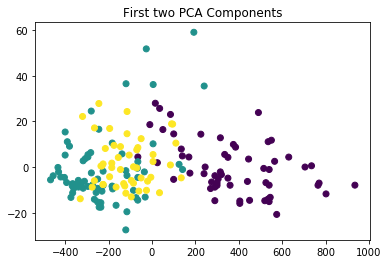

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(transformed[:,0], transformed[:,1], c=y);
ax.set_title('First two PCA Components')

It's fair to say that PCA hasn't done a great job separating the two classes, at least not using only the first two dimensions. This is despite the overwhelming majority of the variance being in the first principal component, as shown above.

## LDA
Let's try LDA now, copying largely from the last example we get this.

In [7]:
mu_total = numpy.mean(X, axis=0)
c0 = X[y==0, :]
c1 = X[y==1, :]
c2 = X[y==2, :]
mu = numpy.array([numpy.mean(c0, axis=0), numpy.mean(c1, axis=0), numpy.mean(c2, axis=0)])
nk,_ = numpy.histogram(y, 3)
nk = nk.reshape((3,1))

Sw = ((X - mu[y,:]).transpose()).dot((X - mu[y,:]))
Sb = numpy.multiply(nk, (numpy.ones((3,1))*mu_total - mu)).transpose().dot((numpy.ones((3,1))*mu_total - mu))

eigval, eigvec = numpy.linalg.eig(numpy.linalg.inv(Sw).dot(Sb))

At this point, we have our LDA transform, and we could sort our Eigenvalues (and vectors) and proceed happily. However there are a couple of things worth considering here. First up, let's look at our eigenvalues.

In [8]:
print(eigval)

[ 0.00000000e+00+0.00000000e+00j  4.10806223e+00+0.00000000e+00j
  9.05295225e+00+0.00000000e+00j  5.26691703e-17+0.00000000e+00j
  7.95033598e-16+0.00000000e+00j  4.23737826e-16+0.00000000e+00j
  1.45394130e-16+2.74772034e-16j  1.45394130e-16-2.74772034e-16j
  3.06453463e-16+0.00000000e+00j -2.83780048e-16+0.00000000e+00j
 -5.56910861e-17+1.47036067e-16j -5.56910861e-17-1.47036067e-16j
 -5.56502799e-17+0.00000000e+00j]


Some of them are not big. And they are (ever so slightly) imaginary. What's going on? Mostly it's a case of machine precision. The matrix inversion can lead to a complex answer, however we see that the imaginary components are all tiny, and thus can be ignored.

To make the values easier to look at, let's draw a graph.

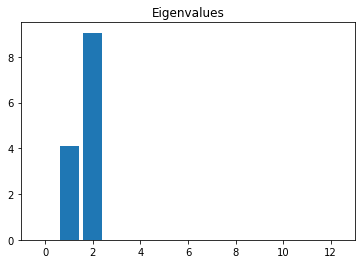

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(range(len(eigval)), numpy.real(eigval));
ax.set_title('Eigenvalues');

From this, while we have $13$ components, only two of them have any value. The others, which all have tiny values, should actually be $0$ - the fact that they aren't is a precision error.

With LDA, the number of discriminants is, at most, $n_{classes} - 1$. In this case, we have $3$ classes, so we have $2$ non-zero eigenvectors. The rest can be ignored. Does this make sense?

Let's consider the point of the LDA transform: to maximise separation between the classes. If we have $2$ classes, we only need one dimension to separate those classes. Similarly with $3$ classes, we need two dimensions. The extra dimension does not add anything in terms of class separation - and as such it has $0$ value and can be discarded.

Keep in mind that with LDA, we can't reproject back to our original space anyway, so the idea that we need to keep all the components to be able to reconstruct or recover the original data doesn't apply anyway.

### LDA, without the maths
In the previous example and above, we did LDA from first principals. That was to make the MATLAB users feel ok. MATLAB doesn't have a good implementation of LDA. Python does, so let's use that now instead.

Python's version actually adds a few bells and whistles we don't care about, so we'll ignore that for now and treat it like the PCA version.

In [10]:
lda = discriminant_analysis.LinearDiscriminantAnalysis()
lda.fit(numpy.array(X), numpy.array(y))
transformed = lda.transform(X)

Note that with LDA, and in particular with this implementation, we don't get all the dimensions back. Regarding the number of components, sklearn's help says

>  n_components : int, optional (default=None) 
>
>      Number of components (<= min(n_classes - 1, n_features)) for
>
>      dimensionality reduction. If None, will be set to
>
>      min(n_classes - 1, n_features).
 
This is as per our discussion above - we only need $n_{classes} - 1$, the rest are crap, so this just get's rid of them for us.

In [11]:
print(numpy.shape(transformed))

(177, 2)


Looking at a plot of our new coefficients, we can see that LDA does a pretty good job of splitting the data up.

Text(0.5, 1.0, 'First Two LDA Components')

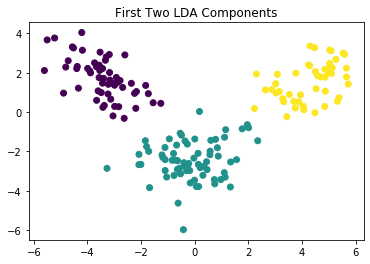

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(transformed[:,0], transformed[:,1], c=y);
ax.set_title('First Two LDA Components')

## Making PCA Great Again
We can actually improve our PCA results a lot. If we look at the mean and std.dev. of each dimension, we'll see something that should give us reason to pause:

In [13]:
print(numpy.mean(X, axis=0))
print(numpy.std(X, axis=0))

[1.29936723e+01 2.33988701e+00 2.36615819e+00 1.95169492e+01
 9.95875706e+01 2.29225989e+00 2.02344633e+00 3.62316384e-01
 1.58694915e+00 5.05480225e+00 9.56983051e-01 2.60429379e+00
 7.45096045e+02]
[8.06520437e-01 1.11614803e+00 2.74302274e-01 3.32663379e+00
 1.41339221e+01 6.24692901e-01 9.95832553e-01 1.24300308e-01
 5.69927900e-01 2.31787089e+00 2.28486854e-01 7.03108259e-01
 3.13993283e+02]


Our last dimension has a much greater range and magnitude than everything else. As such, the vast majority of the variance is captured in it. If we re-scale the data, we get a much better result from our PCA.
In this case, we standardise the data, i.e. we scale the data by subtracting the mean and dividing by the standard deviation.

In [14]:
mu = numpy.mean(X, axis=0)
sigma = numpy.std(X, axis=0)
Xs = (X - mu)/sigma

Text(0.5, 1.0, 'First two PCA Components')

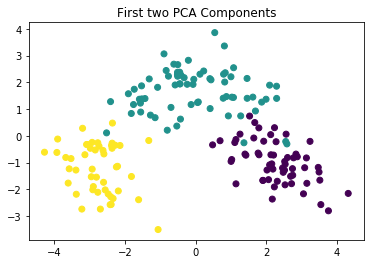

In [15]:
pca = decomposition.PCA()
pca.fit(Xs)
transformed = pca.transform(Xs)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(transformed[:,0], transformed[:,1], c=y);
ax.set_title('First two PCA Components')

In [16]:
print(pca.explained_variance_ratio_)

[0.35983071 0.1924128  0.1117946  0.07111109 0.06628744 0.04960367
 0.04246014 0.02697991 0.02224462 0.01898528 0.01734155 0.01295206
 0.00799613]


And lo, PCA was fixed - or at least was a bit better than it was. We can see from the above, our variance is no longer all in one dimension, and we have better separation between the classes. It's not as good as LDA, but much better than it was. Importantly, we can stll recover the original data from this transform. All we need to do is before we add the mean back to the reconsturctred data, we multiply by the saved std.dev.

### Does this matter for LDA?
Let's find out:

Text(0.5, 1.0, 'First Two LDA Components')

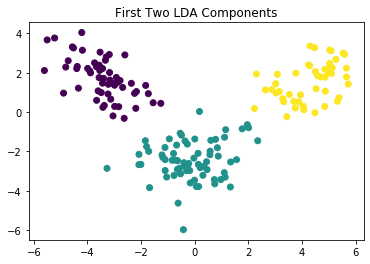

In [17]:
lda = discriminant_analysis.LinearDiscriminantAnalysis()
lda.fit(numpy.array(Xs), numpy.array(y))
transformed = lda.transform(Xs)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(transformed[:,0], transformed[:,1], c=y);
ax.set_title('First Two LDA Components')

No. The process of computing the scatter matrices effectivley takes care of this for us.

## Breaking LDA
We broke PCA a while back, let's break LDA now. 

Rather than create weird and special data, we're just to use as little as possible. Because we only have three classes and 13 dimensions, we need to get rid of a lot of data to do this. We'll drop to 6 samples.

As a side note, I've found it harder to break LDA here than in MATLAB - but it does still break - though not in quite as spectacular fashion. The reason, I suspect, is that numpy is doing slightly more intelligent things when computing the matrix inverse to avoid the matrix becoming singular (or close to), which is what we see cause issues in MATLAB.

I'm going to look at two versions of "breaking". First up is the actually working type.

Text(0.5, 1.0, 'First Two LDA Components')

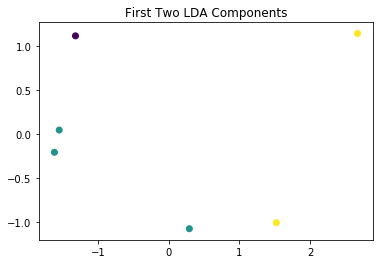

In [18]:
numpy.random.seed(4)
randomRows = numpy.random.randint(len(y), size=6)
Xs_small = Xs[randomRows,:]
y_small = y[randomRows]

lda = discriminant_analysis.LinearDiscriminantAnalysis()
lda.fit(Xs_small, y_small)
transformed = lda.transform(Xs_small)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(transformed[:,0], transformed[:,1], c=y_small);
ax.set_title('First Two LDA Components')

Next up is the failing to separate things type, where we basically get data that's just too sparse and we can't learn a decent transform.

Text(0.5, 1.0, 'First Two LDA Components')

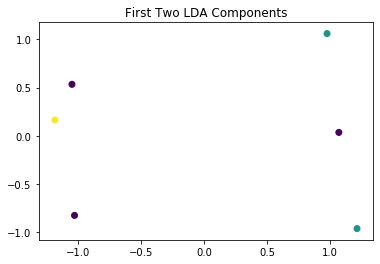

In [19]:
numpy.random.seed(2)
randomRows = numpy.random.randint(len(y), size=6)
Xs_small = Xs[randomRows,:]
y_small = y[randomRows]

lda = discriminant_analysis.LinearDiscriminantAnalysis()
lda.fit(Xs_small, y_small)
transformed = lda.transform(Xs_small)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(transformed[:,0], transformed[:,1], c=y_small);
ax.set_title('First Two LDA Components')

## Final Thoughts

PCA and LDA are both dimension reduction methods, and that's about where the similarities end.

While PCA is also about being able to reconstruct the data, LDA is focussed on maximising class separation. This is great if the aim is classification - it will compress the data, and help improve classification results. However if there is a need to reconstruct the original signal, LDA is not for us.

There are also some differences in terms of data requirements:
* With PCA we need to have more data points than we do dimensions to get a decent projection (and many more data points than dimensions is ideal). 
* With LDA, we now need to also consider how many samples of each class we have. If we have only a few points per class and lots of dimensions, we'll be in trouble - even if we have lots of data points overall. One solution to this is to use PCA first to reduce the number of dimensions.